DATA MANAGING & FRAMING

In [2]:
import pandas as pd
from pathlib import Path

def load_surface_ozone(folder: str) -> pd.DataFrame:
    """
    Scans all VRXZ07.202507* files in `folder`, extracts
    Date + uor200s0, parses to datetime & float, drops
    missing/duplicate entries, and returns only July 1–30, 2025.
    """
    folder_path = Path(folder)
    records = []

    for fp in sorted(folder_path.glob("VRXZ07.202507*.*")):
        # Read raw file, skip 2 header lines, semicolon‐delimited
        df = pd.read_csv(
            fp,
            sep=";",
            skiprows=2,
            na_values="-",
            dtype=str,
            usecols=["Date", "uor200s0"]
        )

        # Rename & convert types
        df = df.rename(columns={"uor200s0": "Ozone_ppb"})
        df["Datetime"] = pd.to_datetime(df["Date"],
                                        format="%Y%m%d%H%M",
                                        errors="coerce")
        df["Ozone_ppb"] = pd.to_numeric(df["Ozone_ppb"], errors="coerce")

        # Drop rows with missing timestamp or ozone
        df = df.dropna(subset=["Datetime", "Ozone_ppb"])

        records.append(df[["Datetime", "Ozone_ppb"]])

    # Concatenate all files
    if not records:
        return pd.DataFrame(columns=["Datetime", "Ozone_ppb"])
    full = pd.concat(records, ignore_index=True)

    # Filter strictly to July 1–30, 2025 (inclusive)
    start = pd.Timestamp("2025-07-01 00:00")
    end   = pd.Timestamp("2025-07-30 23:59:59")
    july = full[(full["Datetime"] >= start) & (full["Datetime"] <= end)].copy()

    # Drop any duplicate timestamps, sort, and reset index
    july = (
        july
        .drop_duplicates(subset="Datetime")
        .sort_values("Datetime")
        .reset_index(drop=True)
    )

    return july


if __name__ == "__main__":
    surface_ozone = load_surface_ozone("SurfaceO3")
    print(f"Extracted {len(surface_ozone)} records for July 1–30, 2025\n")
    print(surface_ozone.head(), "\n...\n", surface_ozone.tail())



Extracted 3061 records for July 1–30, 2025

             Datetime  Ozone_ppb
0 2025-07-01 00:00:00       88.5
1 2025-07-01 00:10:00       88.8
2 2025-07-01 00:20:00       89.4
3 2025-07-01 00:30:00       89.8
4 2025-07-01 00:40:00       90.0 
...
                 Datetime  Ozone_ppb
3056 2025-07-30 11:30:00       39.4
3057 2025-07-30 11:50:00       39.9
3058 2025-07-30 12:10:00       37.5
3059 2025-07-30 12:40:00       39.7
3060 2025-07-30 13:00:00       40.4


SURFACE OZONE SCATTER PLOT

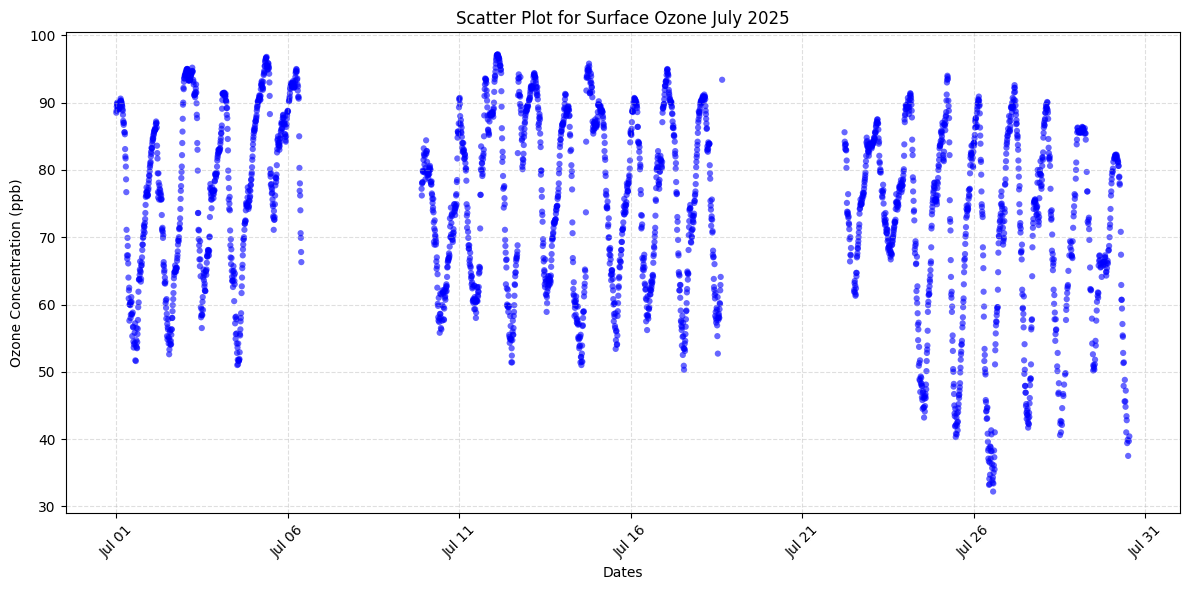

In [3]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# Extract x and y
x = surface_ozone["Datetime"]
y = surface_ozone["Ozone_ppb"]

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Scatter plot
ax.scatter(
    x,
    y,
    s=20,              
    alpha=0.6,         
    color="blue",  
    edgecolor="none"
)

# Format x-axis for dates
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
plt.xticks(rotation=45)

# Labels, title, grid
ax.set_xlabel("Dates")
ax.set_ylabel("Ozone Concentration (ppb)")
ax.set_title("Scatter Plot for Surface Ozone July 2025")
ax.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


SURFACE OZONE TIME SERIES PLOT

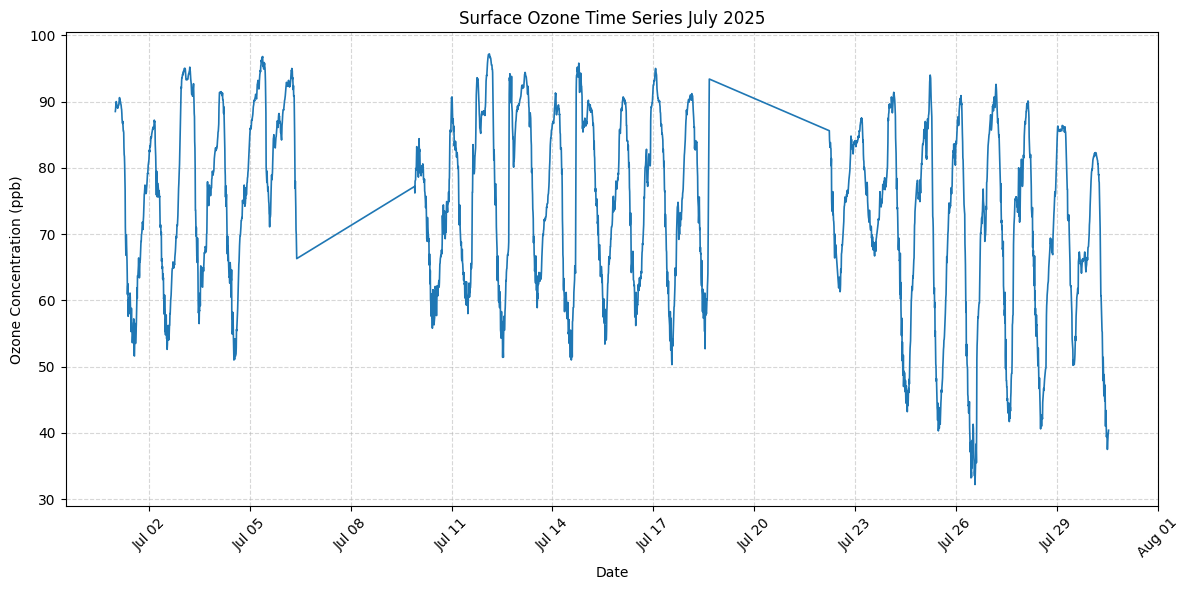

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Set the Datetime column as the index
ts = surface_ozone.set_index("Datetime")["Ozone_ppb"]

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(ts.index, ts.values, color="tab:blue", linewidth=1.2)

# Format the x-axis for dates
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
plt.xticks(rotation=45)

# Labels, title, grid
ax.set_xlabel("Date")
ax.set_ylabel("Ozone Concentration (ppb)")
ax.set_title("Surface Ozone Time Series July 2025")
ax.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


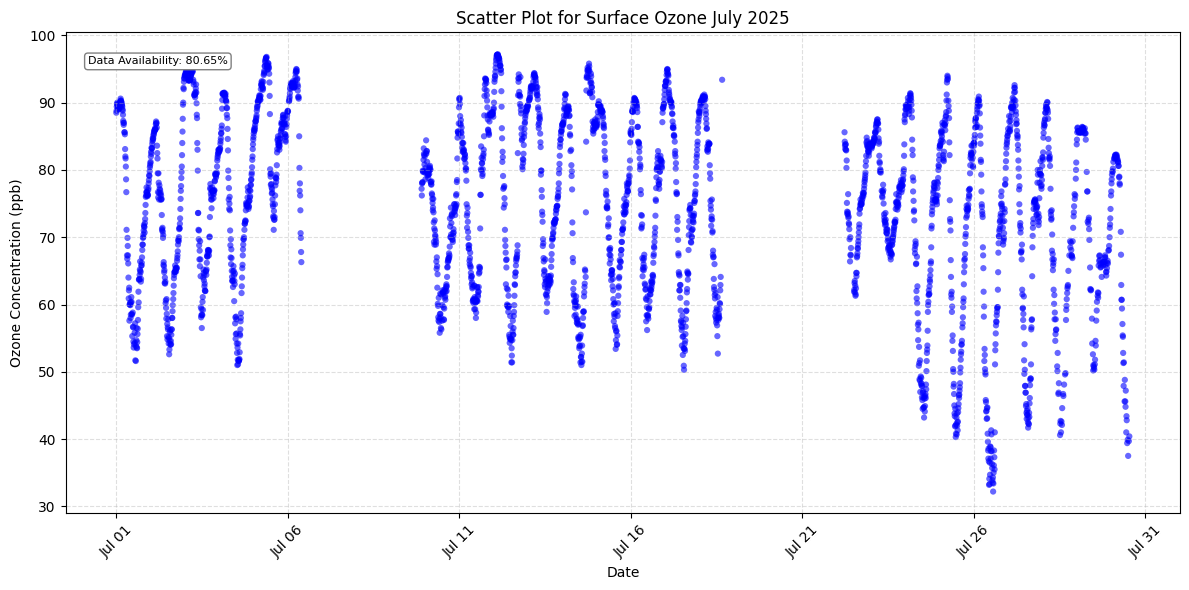

In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Ensure 'Datetime' column is datetime type
surface_ozone["Datetime"] = pd.to_datetime(surface_ozone["Datetime"])

# Filter for July 2025
july_mask = surface_ozone["Datetime"].dt.month == 7
july_data = surface_ozone[july_mask]

# Calculate total expected days and days with data
expected_days = 31
available_days = july_data["Datetime"].dt.date.nunique()
availability_percent = round((available_days / expected_days) * 100, 2)

# Extract x and y
x = july_data["Datetime"]
y = july_data["Ozone_ppb"]

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Scatter plot
ax.scatter(
    x,
    y,
    s=20,              
    alpha=0.6,         
    color="blue",  
    edgecolor="none"
)

# Format x-axis for dates
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
plt.xticks(rotation=45)

# Labels, title, grid
ax.set_xlabel("Date")
ax.set_ylabel("Ozone Concentration (ppb)")
ax.set_title("Scatter Plot for Surface Ozone July 2025")
ax.grid(True, linestyle="--", alpha=0.4)

# Annotate data availability (top-left of plot)
ax.text(
    0.02, 0.95,
    f"Data Availability: {availability_percent}%",
    transform=ax.transAxes,
    fontsize=8,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray')
)

plt.tight_layout()
plt.show()
